In [1]:
import os
import sys
sys.path.append('..')

# metropolis

prior mean: 0, prior std: 1
Posterior mean: 0.35, Posterior std: 0.62


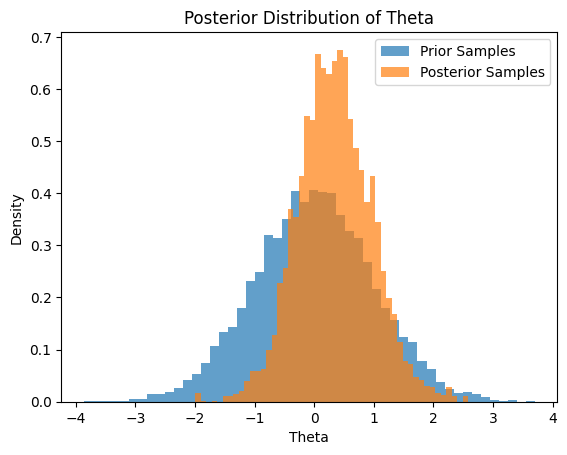

In [3]:
import torch
import torch.distributions as dist

# Define the prior: Normal(mu, sigma)

def prior(theta, mu=0.0, sigma=1.0):
    return dist.Normal(mu, sigma).log_prob(theta)

# Define the likelihood: Bernoulli(f(theta)), where f(theta) = sigmoid(theta)
def likelihood(theta, y, f=None):
    if f is None:
        f_theta = torch.sigmoid(theta)  # f(theta) = logistic function
    else:
        f_theta = f(theta)
    return y * torch.log(f_theta) + (1 - y) * torch.log(1 - f_theta)

# Define the target posterior (up to proportionality)
def log_posterior(theta, y, mu=0.0, sigma=1.0):
    return likelihood(theta, y).sum() + prior(theta, mu, sigma)

# Metropolis-Hastings algorithm
def metropolis_hastings(y, num_samples=10000, burn_in=1000, mu=0.0, sigma=1.0, proposal_std=1.0):
    samples = []
    theta = torch.tensor(0.0)  # Initial value of theta
    current_log_posterior = log_posterior(theta, y, mu, sigma)

    for i in range(num_samples + burn_in):
        # Propose a new theta' using a symmetric proposal distribution
        proposal = torch.normal(theta, proposal_std)  # Gaussian proposal q(theta'|theta)

        # Compute log-posterior for the proposal
        proposed_log_posterior = log_posterior(proposal, y, mu, sigma)

        # Compute the acceptance probability
        acceptance_prob = torch.exp(proposed_log_posterior - current_log_posterior)

        # Accept or reject the proposal
        if torch.rand(1).item() < acceptance_prob:
            theta = proposal
            current_log_posterior = proposed_log_posterior

        # Store the sample after burn-in
        if i >= burn_in:
            samples.append(theta.item())

    return torch.tensor(samples)

# Example usage
# Observations (y): binary data from a Bernoulli distribution
y = torch.tensor([1, 0, 1, 1, 0, 1, 0, 1], dtype=torch.float32)

# Run Metropolis-Hastings
samples = metropolis_hastings(y, num_samples=5000, burn_in=1000, mu=0.0, sigma=1.0, proposal_std=0.5)

mean, std = samples.mean(), samples.std()

print(f"prior mean: 0, prior std: 1")
print(f"Posterior mean: {mean:.2f}, Posterior std: {std:.2f}")

# Analyze and visualize results
import matplotlib.pyplot as plt
# plot prior samples
plt.hist(dist.Normal(0, 1).sample((10000,)).numpy(), bins=50, density=True, alpha=0.7, label='Prior Samples')

# Plot the posterior samples
plt.hist(samples.numpy(), bins=50, density=True, alpha=0.7, label='Posterior Samples')
plt.title("Posterior Distribution of Theta")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.legend()
plt.show()


## metropolis multivariate

/tmp/ipykernel_44160/3264965549.py:73: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(samples)


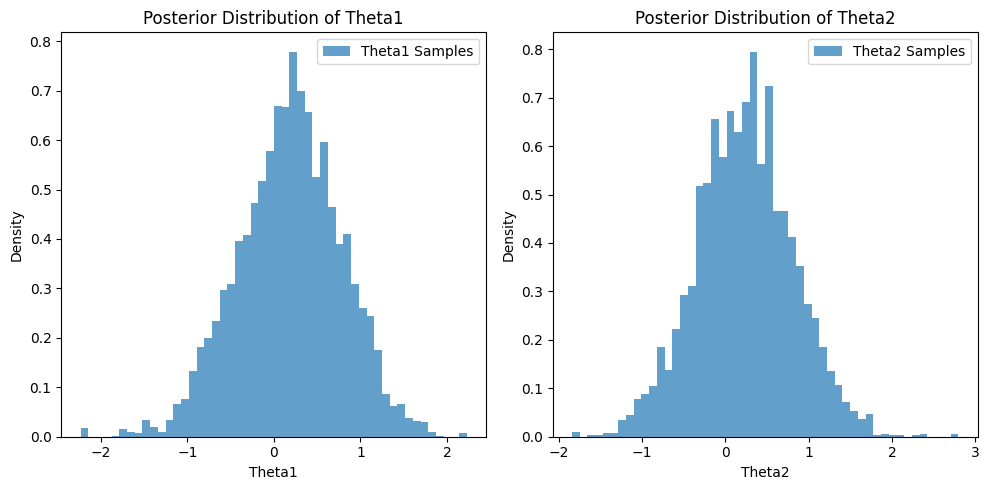

In [4]:
import torch
import torch.distributions as dist

# Define the multivariate Gaussian prior: N(mu, Sigma)
def prior(theta, mu, sigma):
    """
    theta: Tensor of shape (2,) representing [theta1, theta2].
    mu: Tensor of shape (2,) representing [mu1, mu2].
    sigma: Tensor of shape (2, 2), covariance matrix.
    """
    mvn = dist.MultivariateNormal(mu, sigma)
    return mvn.log_prob(theta)

# Define the likelihood: Bernoulli(f(theta)), where f(theta) = sigmoid(w^T theta)
def likelihood(theta, y):
    """
    theta: Tensor of shape (2,) representing [theta1, theta2].
    y: Tensor of observed binary outcomes (0 or 1).
    """
    # Use a linear predictor f(theta) = sigmoid(w^T theta), for example w = [1, 1]
    w = torch.tensor([1.0, 1.0])
    f_theta = torch.sigmoid(torch.dot(w, theta))
    return y * torch.log(f_theta) + (1 - y) * torch.log(1 - f_theta)

# Define the posterior (up to proportionality)
def log_posterior(theta, y, mu, sigma):
    """
    theta: Tensor of shape (2,) representing [theta1, theta2].
    """
    return likelihood(theta, y).sum() + prior(theta, mu, sigma)

# Metropolis-Hastings algorithm
def metropolis_hastings(y, num_samples=10000, burn_in=1000, mu=None, sigma=None, proposal_std=0.5):
    """
    y: Observed binary outcomes (0 or 1).
    num_samples: Number of samples to draw from posterior.
    burn_in: Number of initial samples to discard.
    mu: Tensor of shape (2,) representing the prior mean vector.
    sigma: Tensor of shape (2, 2), the prior covariance matrix.
    proposal_std: Standard deviation for the proposal distribution.
    """
    if mu is None:
        mu = torch.tensor([0.0, 0.0])
    if sigma is None:
        sigma = torch.eye(2)  # Identity covariance matrix by default

    samples = []
    theta = torch.zeros(2)  # Initial value for [theta1, theta2]
    current_log_posterior = log_posterior(theta, y, mu, sigma)

    # Define proposal distribution
    proposal_cov = torch.eye(2) * proposal_std**2

    for i in range(num_samples + burn_in):
        # Propose new theta' using a multivariate normal proposal
        proposal = dist.MultivariateNormal(theta, proposal_cov).sample()

        # Compute the log-posterior for the proposal
        proposed_log_posterior = log_posterior(proposal, y, mu, sigma)

        # Compute acceptance probability
        acceptance_prob = torch.exp(proposed_log_posterior - current_log_posterior)

        # Accept or reject the proposal
        if torch.rand(1).item() < acceptance_prob:
            theta = proposal
            current_log_posterior = proposed_log_posterior

        # Store the sample after burn-in
        if i >= burn_in:
            samples.append(theta.numpy())

    return torch.tensor(samples)

# Example usage
# Observations (y): binary data from a Bernoulli distribution
y = torch.tensor([1, 0, 1, 1, 0, 1, 0, 1], dtype=torch.float32)

# Define prior parameters
mu = torch.tensor([0.0, 0.0])  # Mean of the prior
sigma = torch.tensor([[1.0, 0.5], [0.5, 1.0]])  # Covariance matrix of the prior

# Run Metropolis-Hastings
samples = metropolis_hastings(y, num_samples=5000, burn_in=1000, mu=mu, sigma=sigma, proposal_std=0.5)

# Analyze and visualize results
import matplotlib.pyplot as plt

# Extract theta1 and theta2 samples
theta1_samples = samples[:, 0].numpy()
theta2_samples = samples[:, 1].numpy()

# Plot the posterior samples
plt.figure(figsize=(10, 5))

# Theta1 histogram
plt.subplot(1, 2, 1)
plt.hist(theta1_samples, bins=50, density=True, alpha=0.7, label='Theta1 Samples')
plt.title("Posterior Distribution of Theta1")
plt.xlabel("Theta1")
plt.ylabel("Density")
plt.legend()

# Theta2 histogram
plt.subplot(1, 2, 2)
plt.hist(theta2_samples, bins=50, density=True, alpha=0.7, label='Theta2 Samples')
plt.title("Posterior Distribution of Theta2")
plt.xlabel("Theta2")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()


# variational inference

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

# Define the model and likelihood
def likelihood(y, y_pred, noise_std):
    return Normal(y_pred, noise_std).log_prob(y).sum()

# Define the prior
def prior(theta):
    return Normal(0, 1).log_prob(theta).sum()

# Variational distribution (q_lambda)
class VariationalDistribution(nn.Module):
    def __init__(self, dim):
        super(VariationalDistribution, self).__init__()
        self.mu = nn.Parameter(torch.zeros(dim))
        self.log_sigma = nn.Parameter(torch.zeros(dim))
    
    def sample(self, num_samples=1):
        epsilon = torch.randn(num_samples, self.mu.size(0), device=self.mu.device)
        sigma = torch.exp(self.log_sigma)
        return self.mu + sigma * epsilon  # Reparameterization trick
    
    def log_prob(self, theta):
        sigma = torch.exp(self.log_sigma)
        return Normal(self.mu, sigma).log_prob(theta).sum()

# BBVI Training Loop
def bbvi(X, y, variational_dist, num_epochs=5000, num_samples=10, lr=0.01):
    optimizer = optim.Adam(variational_dist.parameters(), lr=lr)
    noise_std = 0.1  # Observation noise

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Monte Carlo approximation of ELBO
        elbo = 0
        for _ in range(num_samples):
            # Sample theta ~ q_lambda
            theta = variational_dist.sample().squeeze() 
            
            # Predicted y
            y_pred = X @ theta #function of  X=(x,y) and theta sampled from variational distribution q_lambda
            
            # Log likelihood
            log_likelihood = likelihood(y, y_pred, noise_std) # function of y, y_pred and noise_std as observation model of the pomdp
            
            # Log prior
            log_prior = prior(theta)
            
            # Log variational density
            log_q = variational_dist.log_prob(theta)
            
            # ELBO term
            elbo += log_likelihood + log_prior - log_q
        
        elbo /= num_samples  # Average over samples
        
        # Maximize ELBO (minimize negative ELBO)
        loss = -elbo
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, ELBO: {elbo.item():.4f}")

    return variational_dist

# Synthetic data for Bayesian linear regression
torch.manual_seed(42)
X = torch.randn(100, 2)  # 100 samples, 2 features
true_theta = torch.tensor([2.0, -1.0])
y = X @ true_theta + 0.1 * torch.randn(100)
print(X.shape, true_theta.shape, y.shape)

# Initialize variational distribution
variational_dist = VariationalDistribution(dim=2)

# Train with BBVI
trained_dist = bbvi(X, y, variational_dist, num_epochs=100, num_samples=100, lr=0.05)

# Output trained variational parameters
print(f"Variational Mean: {trained_dist.mu.detach().numpy()}")
print(f"Variational Log Std: {trained_dist.log_sigma.detach().numpy()}")


torch.Size([100, 2]) torch.Size([2]) torch.Size([100])
Epoch 100, ELBO: -112.0604
Variational Mean: [ 2.0206351 -0.9992352]
Variational Log Std: [-1.8429017 -1.9003012]


In [78]:
from torch.distributions import Normal

mu = torch.tensor([0.0, 5.0])
sigma = torch.tensor([1.0, 0.5])
mvn = Normal(mu, sigma)
mvn.sample()

tensor([1.7266, 5.5423])

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

# Define the model and likelihood
def likelihood(y, y_pred, noise_std):
    return Normal(y_pred, noise_std).log_prob(y).sum()

# Define the prior
def prior(theta):
    return Normal(0, 1).log_prob(theta).sum()

# Variational distribution (q_lambda)
class VariationalDistribution(nn.Module):
    def __init__(self, dim):
        super(VariationalDistribution, self).__init__()
        self.mu = nn.Parameter(torch.zeros(dim))
        self.log_sigma = nn.Parameter(torch.zeros(dim))
    
    def sample(self, num_samples=1):
        epsilon = torch.randn(num_samples, self.mu.size(0), device=self.mu.device)
        sigma = torch.exp(self.log_sigma)
        return self.mu + sigma * epsilon  # Reparameterization trick
    
    def log_prob(self, theta):
        sigma = torch.exp(self.log_sigma)
        return Normal(self.mu, sigma).log_prob(theta).sum()

# BBVI Training Loop
def bbvi(X, y, variational_dist, num_epochs=5000, num_samples=10, lr=0.01):
    optimizer = optim.Adam(variational_dist.parameters(), lr=lr)
    noise_std = 0.1  # Observation noise

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Monte Carlo approximation of ELBO
        elbo = 0
        for _ in range(num_samples):
            # Sample theta ~ q_lambda
            theta = variational_dist.sample().squeeze() 
            
            # Predicted y
            y_pred = X @ theta #function of  X=(x,y) and theta sampled from variational distribution q_lambda
            
            # Log likelihood
            log_likelihood = likelihood(y, y_pred, noise_std) # function of y, y_pred and noise_std as observation model of the pomdp
            
            # Log prior
            log_prior = prior(theta)
            
            # Log variational density
            log_q = variational_dist.log_prob(theta)
            
            # ELBO term
            elbo += log_likelihood + log_prior - log_q
        
        elbo /= num_samples  # Average over samples
        
        # Maximize ELBO (minimize negative ELBO)
        loss = -elbo
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, ELBO: {elbo.item():.4f}")

    return variational_dist

# Synthetic data for Bayesian linear regression with 4 parameters
torch.manual_seed(42)
X = torch.randn(100, 4)  # 100 samples, 4 features
true_theta = torch.tensor([2.0, -1.0, 0.5, -0.7])
y = X @ true_theta + 0.1 * torch.randn(100)
print(X.shape, true_theta.shape, y.shape)

# Initialize variational distribution for 4 parameters
variational_dist = VariationalDistribution(dim=4)

# Train with BBVI
trained_dist = bbvi(X, y, variational_dist, num_epochs=100, num_samples=100, lr=0.05)

# Output trained variational parameters
print(f"Variational Mean: {trained_dist.mu.detach().numpy()}")
print(f"Variational Log Std: {trained_dist.log_sigma.detach().numpy()}")


torch.Size([100, 4]) torch.Size([4]) torch.Size([100])
Epoch 100, ELBO: -470.8313
Variational Mean: [ 2.0126462  -0.9947886   0.49327692 -0.6927638 ]
Variational Log Std: [-1.7756165 -1.8554561 -1.9046326 -1.8659397]


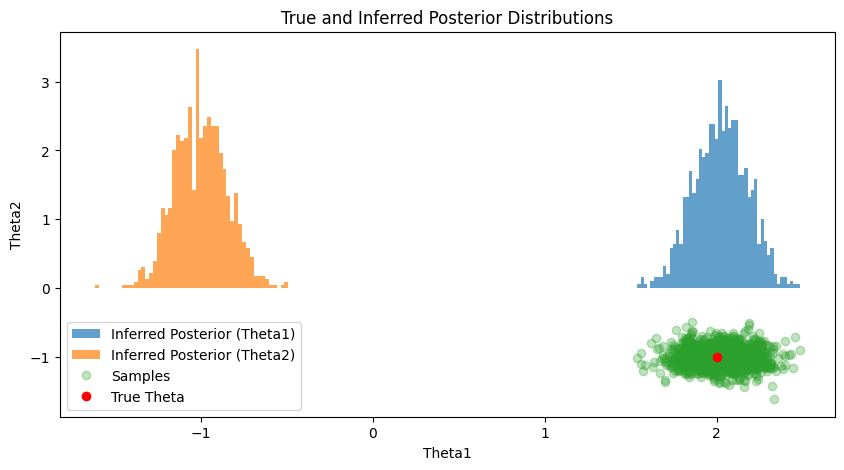

In [6]:
# Plot the true and inferred posterior distributions by sampling
import matplotlib.pyplot as plt

# True posterior
true_posterior = Normal(true_theta, torch.tensor([0.1, 0.1]))

# Inferred posterior
num_samples = 1000
samples = trained_dist.sample(num_samples).detach().numpy()

# Plot the true and inferred posterior distributions
plt.figure(figsize=(10, 5))
plt.hist(samples[:, 0], bins=50, density=True, alpha=0.7, label='Inferred Posterior (Theta1)')
plt.hist(samples[:, 1], bins=50, density=True, alpha=0.7, label='Inferred Posterior (Theta2)')
plt.plot(samples[:, 0], samples[:, 1], 'o', alpha=0.3, label='Samples')
plt.plot(true_theta[0], true_theta[1], 'ro', label='True Theta')
plt.xlabel("Theta1")
plt.ylabel("Theta2")
plt.title("True and Inferred Posterior Distributions")
plt.legend()
plt.show()


In [68]:
from torch.distributions import MultivariateNormal
mu = torch.tensor([0.0, 0.0])
sigma = torch.tensor([[1.0, 0.], [0., 1.0]])
MultivariateNormal(mu, sigma).log_prob(torch.tensor([0.0, 0.0])).sum()

tensor(-1.8379)

# my VI

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

# Define the model and likelihood
def likelihood(y, y_pred, noise_std):
    return Normal(y_pred, noise_std).log_prob(y).sum()

# Define the prior
def prior(theta):
    return Normal(0, 1).log_prob(theta).sum()

# Variational distribution (q_lambda)
class VariationalDistribution(nn.Module):
    def __init__(self, dim):
        super(VariationalDistribution, self).__init__()
        self.mu = nn.Parameter(torch.zeros(dim))
        self.log_sigma = nn.Parameter(torch.zeros(dim))
    
    def sample(self, num_samples=1):
        epsilon = torch.randn(num_samples, self.mu.size(0), device=self.mu.device)
        sigma = torch.exp(self.log_sigma)
        return self.mu + sigma * epsilon  # Reparameterization trick
    
    def log_prob(self, theta):
        sigma = torch.exp(self.log_sigma)
        return Normal(self.mu, sigma).log_prob(theta).sum()

# BBVI Training Loop
def bbvi(X, y, variational_dist, num_epochs=5000, num_samples=10, lr=0.01):
    optimizer = optim.Adam(variational_dist.parameters(), lr=lr)
    noise_std = 0.1  # Observation noise

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Monte Carlo approximation of ELBO
        elbo = 0
        for _ in range(num_samples):
            # Sample theta ~ q_lambda
            theta = variational_dist.sample().squeeze() 
                        
            # Log likelihood p(x|theta)
            log_likelihood = obs_model(x,theta,y)
            
            # Log prior
            log_prior = prior(theta)
            
            # Log variational density
            log_q = variational_dist.log_prob(theta)
            
            # ELBO term
            elbo += log_likelihood + log_prior - log_q
        
        elbo /= num_samples  # Average over samples
        
        # Maximize ELBO (minimize negative ELBO)
        loss = -elbo
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, ELBO: {elbo.item():.4f}")

    return variational_dist


In [6]:
import torch.functional as F
import torch.nn as nn
import torch
class VAE(nn.Module):
    def __init__(self, obs_model):
        super(VAE, self).__init__()

        
        self.obs_model = obs_model
        self.obs_model.eval()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        # this should be replaced by the observation model p(x|z)
        return self.obs_model(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar




# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.BCELoss(recon_x, x, reduction='sum') #

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # replace with KL for arbitrary prior

    return BCE + KLD

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
obs_model = nn.Sequential(
    nn.Linear(20, 400),
    nn.ReLU(),
    nn.Linear(400, 784),
    nn.Sigmoid()
).to(device)

In [13]:
model = VAE(obs_model=obs_model).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)